Creacion de set de entrenamiento (sentences, next_words)



In [1]:

# Parameters: change to experiment different configurations
SEQUENCE_LEN = 5
MIN_WORD_FREQUENCY = 1
STEP = 1
BATCH_SIZE = 512

import os,io
import codecs
import numpy as np
import unicodedata



def print_vocabulary(words_file_path, words_set):
    words_file = codecs.open(words_file_path, 'w', encoding='utf8')
    for w in words_set:
        if w != "\n":
            words_file.write(w+"\n")
        else:
            words_file.write(w)
    words_file.close()

def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
    # shuffle at unison
    print('Shuffling sentences')

    tmp_sentences = []
    tmp_next_word = []
    for i in np.random.permutation(len(sentences_original)):
        tmp_sentences.append(sentences_original[i])
        tmp_next_word.append(next_original[i])

    cut_index = int(len(sentences_original) * (1.-(percentage_test/100.)))
    x_train, x_test = tmp_sentences[:cut_index], tmp_sentences[cut_index:]
    y_train, y_test = tmp_next_word[:cut_index], tmp_next_word[cut_index:]

    print("Size of training set = %d" % len(x_train))
    print("Size of test set = %d" % len(y_test))
    return (x_train, y_train), (x_test, y_test)



corpus = "corpus.txt"
examples = "examples.txt"
vocabulary = "vocabulary.txt"

if not os.path.isdir('./checkpoints/'):
    os.makedirs('./checkpoints/')

symbols = ['\n','?','¿',',','.','"',':',"'",'(',')']
with io.open(corpus, encoding='utf-8') as f:
    text = f.read().lower().replace('\xa0', ' ').replace('-','')
    for s in symbols:
        text = text.replace(s,' '+s+' ')

text = unicodedata.normalize('NFC',text)
print('Corpus length in characters:', len(text))


# Separar por palabras
text_in_words = [w for w in text.split(' ') if (w.strip() != '' or w == '\n') and w != "(...)"]

print(text_in_words)
print('Corpus length in words:', len(text_in_words))

# Calculate word frequency
word_freq = {}
for word in text_in_words:
    word_freq[word] = word_freq.get(word, 0) + 1

ignored_words = set()
for k, v in word_freq.items():
    if word_freq[k] < MIN_WORD_FREQUENCY:
        ignored_words.add(k)

print('Ignoring: ',ignored_words)

words = set(text_in_words)
print('Unique words before ignoring:', len(words))
print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
words = sorted(set(words) - ignored_words)
print(words)
print('Unique words after ignoring:', len(words))
print_vocabulary(vocabulary, words)

word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))

# cut the text in semi-redundant sequences of SEQUENCE_LEN words
sentences = []
next_words = []
ignored = 0
for i in range(0, len(text_in_words) - SEQUENCE_LEN, STEP):
    # Only add the sequences where no word is in ignored_words
    if len(set(text_in_words[i: i+SEQUENCE_LEN+1]).intersection(ignored_words)) == 0:
        sentences.append(text_in_words[i + 1: i + SEQUENCE_LEN + 1])
        next_words.append(text_in_words[i])
    else:
        ignored = ignored + 1
print('Ignored sequences:', ignored)
print('Remaining sequences:', len(sentences))

# x, y, x_test, y_test
(sentences, next_words), (sentences_test, next_words_test) = shuffle_and_split_training_set(
    sentences, next_words
)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Ignoring:  set()
Unique words before ignoring: 28209
Ignoring words with frequency < 1
['\n', '!', '!!', '!!!', '!!ay', '!!shii', '"', '##', '###', '#mododiablo', '&amp;', "'", '(', ')', ',', '.', '/', '0', '00', '000', '00911915', '028', '05', '06', '0600', '07', '0800', '0800808', '0800donrouch', '1', '10', '100', '1000', '100k', '105', '11', '110', '1100', '1107', '12', '120', '13', '1312', '135', '14', '15', '150', '15k', '16', '17', '18', '180', '1874', '19', '190', '2', '20', '200', '2000', '2002', '2003', '2006', '2007', '2009', '2010', '2011', '2012', '2014', '2015', '2016', '2019', '2020', '2026', '2028', '2030', '2050', '21', '212', '22', '23', '230', '24', '24/7', '247', '25', '25k', '26', '27', '2900', '2c', '2e', '2pac', '2x', '2x3', '2x4', '3', '30', '300', '3000', '305', '308', '30g', '31', '315', '317', '32', '35', '35k', '37', '38', '3d', '3k', '4', '40', '400', '40ty', '420', '44', '4444', '47', '4am', '4g', '5', '50', '50/50', '500', '50505050', '542', '58', '6', '60

Creacion de modelo y entrenamiento extraido de https://github.com/enriqueav/lstm_lyrics

In [ ]:
"""
Example script to train a network to generate text with the style of a given corpus
--By word--

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

Based on
https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py

20 epochs should be enough to get decent results.
Uses data generator to avoid loading all the test set into memory.
Saves the weights and model every epoch.
"""

from __future__ import print_function
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
import numpy as np
import sys
import io
import os
from google.colab import files

# Data generator for fit and evaluate
def generator(sentence_list, next_word_list, batch_size):
    index = 0
    while True:
        x = np.zeros((batch_size, SEQUENCE_LEN, len(words)), dtype=np.bool)
        y = np.zeros((batch_size, len(words)), dtype=np.bool)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index % len(sentence_list)]):
                x[i, t, word_indices[w]] = 1
            y[i, word_indices[next_word_list[index % len(sentence_list)]]] = 1
            index = index + 1
        yield x, y


def get_model(dropout=0.2):
    print('Build model...')
    model = Sequential()
    model.add(Bidirectional(LSTM(128), input_shape=(SEQUENCE_LEN, len(words))))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    return model


# Functions from keras-team/keras/blob/master/examples/lstm_text_generation.py
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)

    # Randomly pick a seed sequence
    seed_index = np.random.randint(len(sentences+sentences_test))
    seed = (sentences+sentences_test)[seed_index]

    for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
        sentence = seed
        examples_file.write('----- Diversity:' + str(diversity) + '\n')
        examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
        examples_file.write(' '.join(sentence))

        for i in range(50):
            x_pred = np.zeros((1, SEQUENCE_LEN, len(words)))
            for t, word in enumerate(sentence):
                x_pred[0, t, word_indices[word]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_word = indices_word[next_index]

            sentence = sentence[1:]
            sentence.append(next_word)

            examples_file.write(" "+next_word)
        examples_file.write('\n')
    examples_file.write('='*80 + '\n')
    examples_file.flush()


model = get_model(0.4)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

file_path = "./checkpoints/LSTM_LYRICS-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
            "loss{loss:.4f}-acc{accuracy:.4f}-val_loss{val_loss:.4f}-val_acc{val_accuracy:.4f}" % \
            (len(words), SEQUENCE_LEN, MIN_WORD_FREQUENCY)

checkpoint = ModelCheckpoint(filepath=file_path, monitor='val_accuracy', save_best_only=True)
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping = EarlyStopping(monitor='accuracy', patience=5)
callbacks_list = [checkpoint, print_callback, early_stopping]

examples_file = open(examples, "w")

if 'weights_bk_word.h5' in os.listdir():
  print("Weights loaded")
  model.load_weights('weights_bk_word.h5')

history = model.fit_generator(generator(sentences, next_words, BATCH_SIZE),
                    steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
                    epochs=50,
                    callbacks=callbacks_list,
                    validation_data=generator(sentences_test, next_words_test, BATCH_SIZE),
                    validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1)



model.save_weights('weights_bk_word.h5')
#files.download('weights_10_10_bk.h5')

Build model...
Weights loaded
Epoch 1/15
1574/1574 [==============================] - 42s 26ms/step - loss: 2.4135 - accuracy: 0.5224 - val_loss: 8.2403 - val_accuracy: 0.2263
Epoch 2/15
1574/1574 [==============================] - 41s 26ms/step - loss: 2.2725 - accuracy: 0.5417 - val_loss: 5.8841 - val_accuracy: 0.2225
Epoch 3/15
1574/1574 [==============================] - 41s 26ms/step - loss: 2.0812 - accuracy: 0.5633 - val_loss: 6.4449 - val_accuracy: 0.2263
Epoch 4/15
1574/1574 [==============================] - 41s 26ms/step - loss: 1.9220 - accuracy: 0.5810 - val_loss: 9.0322 - val_accuracy: 0.2206
Epoch 5/15
1574/1574 [==============================] - 41s 26ms/step - loss: 1.7771 - accuracy: 0.6006 - val_loss: 7.1186 - val_accuracy: 0.2273
Epoch 6/15
1574/1574 [==============================] - 41s 26ms/step - loss: 1.6756 - accuracy: 0.6134 - val_loss: 6.2045 - val_accuracy: 0.2273
Epoch 7/15
1574/1574 [==============================] - 41s 26ms/step - loss: 1.5813 - accurac

Build model...
Epoch 1/50
1109/1109 [==============================] - 356s 313ms/step - loss: 6.6338 - accuracy: 0.1281 - val_loss: 5.6451 - val_accuracy: 0.1767
Epoch 2/50
1109/1109 [==============================] - 366s 330ms/step - loss: 5.4323 - accuracy: 0.1963 - val_loss: 5.1740 - val_accuracy: 0.2308
Epoch 3/50
1109/1109 [==============================] - 365s 329ms/step - loss: 4.8209 - accuracy: 0.2608 - val_loss: 4.8986 - val_accuracy: 0.2706
Epoch 4/50
1109/1109 [==============================] - 365s 329ms/step - loss: 4.2142 - accuracy: 0.3224 - val_loss: 4.7894 - val_accuracy: 0.3020
Epoch 5/50
1109/1109 [==============================] - 366s 330ms/step - loss: 3.6024 - accuracy: 0.3873 - val_loss: 4.7718 - val_accuracy: 0.3179
Epoch 6/50
1109/1109 [==============================] - 365s 329ms/step - loss: 3.0497 - accuracy: 0.4525 - val_loss: 4.7656 - val_accuracy: 0.3352
Epoch 7/50
1109/1109 [==============================] - 366s 330ms/step - loss: 2.5944 - accuracy

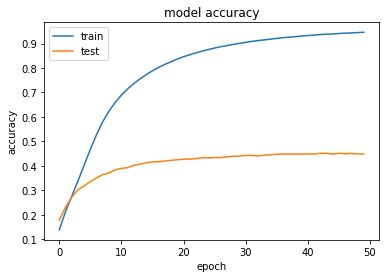

In [2]:
"""
Example script to train a network to generate text with the style of a given corpus
--By word--
It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.
Based on
https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py
20 epochs should be enough to get decent results.
Uses data generator to avoid loading all the test set into memory.
Saves the weights and model every epoch.
"""

from __future__ import print_function
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
import numpy as np
import sys
import json
import os
import matplotlib.pyplot as plt

BATCH_SIZE = 512


# Data generator for fit and evaluate
def generator(sentence_list, next_word_list, batch_size):
    index = 0
    while True:
        x = np.zeros((batch_size, SEQUENCE_LEN, len(words)), dtype=np.bool)
        y = np.zeros((batch_size, len(words)), dtype=np.bool)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index % len(sentence_list)]):
                x[i, t, word_indices[w]] = 1
            y[i, word_indices[next_word_list[index % len(sentence_list)]]] = 1
            index = index + 1
        yield x, y



def get_model(dropout=0.2):
    print('Build model...')
    model = Sequential()
    model.add(Bidirectional(LSTM(256), input_shape=(SEQUENCE_LEN, len(words))))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    return model

def get_custom_model(dropout=0.2):
    print('Build custom model...')
    inputs = Keras.Input(shape=(SEQUENCE_LENGTH, len(words)))
    bidirectional = Bidirectional(LSTM(128))
    x = bidirectional(inputs)
    if dropout > 0:
      x = Dropout(drouput)(x)
    x = Dense(len(words))(x)
    outputs = Activation('softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="custom_model")
    return model



# Functions from keras-team/keras/blob/master/examples/lstm_text_generation.py
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)

    # Randomly pick a seed sequence
    seed_index = np.random.randint(len(sentences+sentences_test))
    seed = (sentences+sentences_test)[seed_index]

    for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
        sentence = seed
        examples_file.write('----- Diversity:' + str(diversity) + '\n')
        examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
        examples_file.write(' '.join(sentence))

        for i in range(50):
            x_pred = np.zeros((1, SEQUENCE_LEN, len(words)))
            for t, word in enumerate(sentence):
                x_pred[0, t, word_indices[word]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_word = indices_word[next_index]

            sentence = sentence[1:]
            sentence.append(next_word)

            examples_file.write(" "+next_word)
        examples_file.write('\n')
    examples_file.write('='*80 + '\n')
    examples_file.flush()


model = get_model()
if 'weights_bk.h5' in os.listdir():
  print('Weights loaded')
  model.load_weights('weights_bk.h5')
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

file_path = "./checkpoints/LSTM_LYRICS-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
            "loss{loss:.4f}-acc{accuracy:.4f}-val_loss{val_loss:.4f}-val_acc{val_accuracy:.4f}" % \
            (len(words), SEQUENCE_LEN, MIN_WORD_FREQUENCY)

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True)
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callbacks_list = [checkpoint, print_callback, early_stopping]

examples_file = open(examples, "w")
history = model.fit(generator(sentences, next_words, BATCH_SIZE),
                    steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
                    epochs=50,
                    callbacks=callbacks_list,
                    validation_data=generator(sentences_test, next_words_test, BATCH_SIZE),
                    validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1)

with io.open('history_bk.json', 'w') as history_file:
    json.dump(history.history, history_file)

model.save_weights("weights_bk.h5")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [3]:
model.save_weights('weights_bk.h5')
files.download('weights_bk.h5')
files.download('history_bk.json')

NameError: ignored

Generacion de texto con el modelo anterior

In [ ]:
"""
Script to generate text from an already trained network (with lstm_train.py)
--By word--

It is necessary to at least provide the trained model and the vocabulary file
(generated also by lstm_train.py).
"""


import argparse
import numpy as np
import re
from keras.models import load_model

import collections


def validate_syllable(s, vocabulary, debug = False):
    if s in vocabulary:
        if debug: print(s, " ✓ in vocabulary")
        return True
    else:
        if debug: print(s, " ✗ NOT in vocabulary")
        return False


def validate_seed(vocabulary, seed, debug = False):
    if debug: print("Validating that all the words in the seed are part of the vocabulary: ", seed)
    
    return all([validate_syllable(s, vocabulary, debug) for s in seed])


# Functions from keras-team/keras/blob/master/examples/lstm_text_generation.py
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def rima(old_syl, next_syl):        
    vowels = ['a','e','i','o','u','á', 'é', 'í', 'ó', 'ú', 'y']
    if old_syl==next_syl:
        return 0.6
    old_strip="".join(filter(lambda c: c in vowels, old_syl))
    next_strip="".join(filter(lambda c: c in vowels, next_syl))
    return 0.2 if (old_strip != "" and old_strip == next_strip) else 0


def rhyme_score(preds, previous_syllables, indices_word, debug = False):
    #Previous syllables es la ultima o dos ultimas silabas concatenadas
    prev = preds.copy()
    for index in range(len(preds)):
        #if(preds[index]) > 0.5: #Modificar a verdaderas candidatas a sílaba
        preds[index] += (1.0 - preds[index])*rima(previous_syllables,indices_word[index])

    if debug: print("Rimando con ", previous_syllables, [indices_word[x] for x in range(len(preds)) if (prev[x] != preds[x])])
    return preds


def generate_text(model, indices_word, word_indices, seed,
                  sequence_length, diversity, quantity):
    """
    Similar to lstm_train::on_epoch_end
    Used to generate text using a trained model

    :param model: the trained Keras model (with model.load)
    :param indices_word: a dictionary pointing to the words
    :param seed: a string to be used as seed (already validated and padded)
    :param sequence_length: how many words are given to the model to generate
    :param diversity: is the "temperature" of the sample function (usually between 0.1 and 2)
    :param quantity: quantity of words to generate
    :return: Nothing, for now only writes the text to console
    """
    print("----- Generating text")
    print("----- Diversity:" + str(diversity))
    print("----- Generating with seed:", seed)

    text = seed.copy()
    sentence = list(reversed(seed))
    prev_preds = []
    last_syllables = [[sentences[-2:]]]
    diff = []

    for i in range(quantity):
        x_pred = np.zeros((1, sequence_length, len(vocabulary)))
        for t, word in enumerate(sentence):
            x_pred[0, t, word_indices[word]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        # preds tiene arreglo resultado de softmax

        next_index = sample(preds, diversity)
        next_word = indices_word[next_index]

        if len(text) > 1 and text[0] == '\n' and last_syllables != []:
                changed_index = sample(rhyme_score(preds, last_syllables[-1][-1], indices_word))
                new_word = indices_word[changed_index]
                if new_word != next_word:
                    diff.insert(0,(next_word, new_word.upper()))
                    next_word = new_word
                    text.insert(0,next_word.upper())
                else:
                    text.insert(0,next_word)
        else:
            text.insert(0,next_word)
        
        sentence = sentence[:-1]
        sentence.insert(0,next_word)
        
        if len(text) > 2 and text[2] == '\n' and '\n' not in text[:2]:
            last_syllables.append(sentence[:2])

    print("\nPares (silabas reemplazadas, silabas originales):")
    print(diff,"\n")
    return text

vocabulary_file = "vocabulary.txt"
#model_file = args.network
seed = "voy a ser el que en el"
seed = seed.split(' ')
sequence_length = SEQUENCE_LEN
diversity = 0.7
quantity = 500

#model = load_model(model_file)
print("\nSummary of the Network: ")
model.summary()
print()

vocabulary = open(vocabulary_file, "r").readlines()
# remove the \n at the end of the word, except for the \n word itself
vocabulary = [re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]

#vocabulary = sorted(set(vocabulary))
vocabulary = sorted(vocabulary)

word_indices = dict((c, i) for i, c in enumerate(vocabulary))
indices_word = dict((i, c) for i, c in enumerate(vocabulary))

if validate_seed(vocabulary, seed, True):
    print("\nSeed is correct.\n")
    # repeat the seed in case is not long enough, and take only the last elements
    seed = (seed*sequence_length)[-sequence_length:]
    text = generate_text(
        model, indices_word, word_indices, seed, sequence_length, diversity, quantity
    )
    for word in text: print(word, ' ', end="")
else:
    print('\033[91mERROR: Please fix the seed string\033[0m')



Summary of the Network: 
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 256)               6445056   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6165)              1584405   
_________________________________________________________________
activation_2 (Activation)    (None, 6165)              0         
Total params: 8,029,461
Trainable params: 8,029,461
Non-trainable params: 0
_________________________________________________________________

Validating that all the words in the seed are part of the vocabulary:  ['voy', 'a', 'ser', 'el', 'que', 'en', 'el']
voy  ✓ in vocabulary
a  ✓ in vocabulary
ser  ✓ in vocabulary
el  ✓ in vocabulary
que  ✓ in vocabula